# Validation Analysis

## Objective
Develop accuracy assessments for tree cover predictions in each country, region, subregion, ecoregion and biome to understand how the model performs differently in each class and determine where we need more data.  
Ultimately we want report that the error of the model at predicting tree cover was x +/- y at the 95% confidence level. 

How confident are we that a certain range around these estimates of tree cover actually contains the true parameter? In other words, what do the error bars look like for precision, recall and f1? How granular can we make these validation assessments for each region/subregion/ecoregion? 

**Steps**
- Bootstrap sample n times from each biome
- Calculate precision, recall and F1 scores for each bootstrap
- Calculate 75%, 95%, 99% confidence intervals for the samples
- Repeat for other categories and see what the error bars look like
- Visualize error bars


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

## Quick EDA

In [202]:
df = pd.read_csv('validation_data.csv')

In [203]:
df['subregion_cover'] = df['subregion'] + "-" +  df['IPCC_Cover']

In [204]:
df.columns

Index(['field_1', 'plot_id', 'lat', 'long', 'y', 'error', 'tp', 'fp', 'fn',
       'tree_cover', 'sovereignt', 'continent', 'region_un', 'subregion',
       'saafricalul', 'land cover', 'IPCC_Cover', 'ECO_NAME', 'Biome',
       'subregion_cover'],
      dtype='object')

In [205]:
df.region_un.value_counts()

Africa      704
Americas    642
Name: region_un, dtype: int64

In [206]:
df.subregion.value_counts()

South America                    452
Eastern and Southern Africa      352
Western and Central Africa       244
Central America and Caribbean    190
Northern Africa                  108
Name: subregion, dtype: int64

In [207]:
df.ECO_NAME.value_counts()[:10]

Sahelian Acacia Savanna                       93
West Sudanian Savanna                         61
Cerrado                                       51
Humid Pampas                                  35
Mediterranean Woodlands And Forests           35
Central Zambezian Miombo Woodlands            28
Valdivian Temperate Forests                   21
Ethiopian Montane Grasslands And Woodlands    21
Uruguayan Savanna                             21
Southern Miombo Woodlands                     20
Name: ECO_NAME, dtype: int64

In [208]:
df.Biome.value_counts()

Tropical and Subtropical Grasslands, Savannas and Shrublands    509
Tropical and Subtropical Moist Broadleaf Forests                294
Tropical and Subtropical Dry Broadleaf Forests                  162
Deserts and Xeric Shrublands                                     88
Mediterranean Forests, Woodlands and Scrub                       75
Montane Grasslands and Shrublands                                65
Temperate Grasslands, Savannas and Shrublands                    60
Tropical and Subtropical Coniferous Forests                      31
Flooded Grasslands and Savannas                                  31
Temperate Broadleaf and Mixed Forests                            25
Mangroves                                                         4
Temperate Conifer Forests                                         3
Inland Water                                                      1
Name: Biome, dtype: int64

In [209]:
df.tree_class.value_counts(normalize=True)*100

AttributeError: 'DataFrame' object has no attribute 'tree_class'

## Bootstrap from each scale, calculate scores and confidence intervals

In [233]:
def bootstrap(df, scale, n):
    
    '''
    Function takes in a df, bootstraps n samples from each category in a column (scale) 
    and calculates the precision, recall and f1. Then takes percentiles of the bootstrap 
    to calculate confidence intervals. Returns separate dfs with the scores and CIs.
    '''
    
    # get a list of categories within the scale, dropping categories with less than 5 rows
    df = df.groupby(scale).filter(lambda x: len(x)>5)   
    categories = set(df[scale].dropna().unique())
    print(f'{scale} has {len(categories)} subcategories. {len(categories)*n} samples in total.')
    
                     
    # empty df to store samples, scores and CIs
    val_df = pd.DataFrame(columns = ['scale', 'category', 'precision', 'recall', 'f1'])
    conf_int = pd.DataFrame(columns = ['scale', 'category',
                                       'p_lower_95', 'p_upper_95', 'r_lower_95',
                                       'r_upper_95', 'f1_lower_95','f1_upper_95',
                                       'p_lower_90', 'p_upper_90', 'r_lower_90',
                                       'r_upper_90', 'f1_lower_90','f1_upper_90',
                                       'p_lower_80', 'p_upper_80', 'r_lower_80',
                                       'r_upper_80', 'f1_lower_80','f1_upper_80'])

    # calculation for precision, recall, f1
    def calculate_metrics(tp, fp, fn):
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2 * ((precision * recall) / (precision + recall))
        return precision, recall, f1
    
    # for each category in scale, calculate scores, 
    for i in categories:
        grouped = df[df[scale] == i]
        bootsamples = pd.DataFrame()
        
        for num in range(n):  
            bootstrap = grouped.sample(len(grouped), replace=True)
            #bootsamples = bootsamples.append(bootstrap, ignore_index = True)
            precision, recall, f1 = calculate_metrics(sum(bootstrap.tp.values), 
                                                      sum(bootstrap.fp.values), 
                                                      sum(bootstrap.fn.values))
            
            # add calculations to empty df
            val_df = val_df.append({'scale': scale, 
                                   'category': i,
                                   'precision': precision,
                                   'recall': recall,
                                   'f1': f1}, ignore_index = True)
    
    # use scores in val_df to calculate CIs
    for i in categories:
        grouped2 = val_df[val_df.category == i] 

        # calculate 80, 90, 95th percentile
        p_lower_95, r_lower_95, f1_lower_95 = np.percentile(grouped2.precision.values, 2.5),\
                                              np.percentile(grouped2.recall.values, 2.5),\
                                              np.percentile(grouped2.f1.values, 2.5) 
        p_upper_95, r_upper_95, f1_upper_95 = np.percentile(grouped2.precision.values, 97.5),\
                                              np.percentile(grouped2.recall.values, 97.5),\
                                              np.percentile(grouped2.f1.values, 97.5)
                

        p_lower_90, r_lower_90, f1_lower_90 = np.percentile(grouped2.precision.values, 5),\
                                              np.percentile(grouped2.recall.values, 5),\
                                              np.percentile(grouped2.f1.values, 5) 
        p_upper_90, r_upper_90, f1_upper_90 = np.percentile(grouped2.precision.values, 95),\
                                              np.percentile(grouped2.recall.values, 95),\
                                              np.percentile(grouped2.f1.values, 95)
        

        p_lower_80, r_lower_80, f1_lower_80 = np.percentile(grouped2.precision.values, 10),\
                                              np.percentile(grouped2.recall.values, 10),\
                                              np.percentile(grouped2.f1.values, 10) 
        p_upper_80, r_upper_80, f1_upper_80 = np.percentile(grouped2.precision.values, 90),\
                                              np.percentile(grouped2.recall.values, 90),\
                                              np.percentile(grouped2.f1.values, 90)
        
        
        # add percentiles to empty df
        conf_int = conf_int.append({'scale': scale, 
                                    'category': i,
                                   'p_lower_95': p_lower_95, 
                                   'p_upper_95': p_upper_95, 
                                   'r_lower_95': r_lower_95,
                                   'r_upper_95': r_upper_95, 
                                   'f1_lower_95': f1_lower_95,
                                   'f1_upper_95': f1_upper_95,
                                   'p_lower_90': p_lower_90, 
                                   'p_upper_90': p_upper_90, 
                                   'r_lower_90': r_lower_90,
                                   'r_upper_90': r_upper_90, 
                                   'f1_lower_90': f1_lower_90,
                                   'f1_upper_90': f1_upper_90,
                                   'p_lower_80': p_lower_80, 
                                   'p_upper_80': p_upper_80, 
                                   'r_lower_80': r_lower_80,
                                   'r_upper_80': r_upper_80, 
                                   'f1_lower_80': f1_lower_80,
                                   'f1_upper_80': f1_upper_80}, ignore_index = True)
        
    # add columns with the mean precision, recall and f1 to CI dataframe (pd can only merge 2 df at a time)
    conf_int = pd.merge(conf_int, val_df.groupby(['category']).precision.mean().reset_index(), on='category')
    conf_int = pd.merge(conf_int, val_df.groupby(['category']).recall.mean().reset_index(), on='category')
    conf_int = pd.merge(conf_int, val_df.groupby(['category']).f1.mean().reset_index(), on='category')
    
    # add column with # of samples to CI dataframe
    sample_size = df[scale].value_counts().to_frame().reset_index()
    sample_size.columns = ['category', 'num_samples']
    conf_int = pd.merge(conf_int, sample_size, on='category')

    # returns scores and conf intervals separately
    return val_df, conf_int

In [241]:
subregion_val, subregion_conf = bootstrap(df, 'subregion', 1000)

subregion has 5 subcategories. 5000 samples in total.


In [14]:
biome_val, biome_conf = bootstrap(df, 'Biome', 50)

Biome has 10 subcategories. 500 samples in total.


In [16]:
region_val, region_conf = bootstrap(df, 'region_un', 50)

region_un has 2 subcategories. 100 samples in total.


In [50]:
country_val, country_conf = bootstrap(df, 'country', 1000)

country has 48 subcategories. 48000 samples in total.


/Users/jessicaertel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


In [242]:
lulc_val, lulc_conf = bootstrap(df, 'IPCC_Cover', 1000)

IPCC_Cover has 6 subcategories. 6000 samples in total.


In [51]:
treeclass_val, treeclass_conf = bootstrap(df, 'tree_class', 1000)

tree_class has 5 subcategories. 5000 samples in total.


In [371]:
subcover, subcover_conf = bootstrap(df, 'subregion_cover', 100)

subregion_cover has 25 subcategories. 2500 samples in total.


<ipython-input-233-2aac4016c32d>:27: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)
<ipython-input-233-2aac4016c32d>:28: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp / (tp + fn)
<ipython-input-233-2aac4016c32d>:29: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * ((precision * recall) / (precision + recall))


In [217]:
subcover_conf = subcover_conf.sort_values("category", ascending = False)

## Visuals: Pointplot + Errorplot

In [373]:
from matplotlib.transforms import ScaledTranslation

def errorplot_precision_recall(conf_df, figsize, title):
    
    font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}
    
    plt.rc('font', **font)

    
    fig, ax = plt.subplots(figsize=figsize)
    #ax.figure(figsize=figsize)

    x_p = conf_df.precision
    x_r = conf_df.recall
    y = conf_df.category

    # define precalculated error bars
    p_lower_95 = conf_df['precision'] - conf_df['p_lower_95'] 
    p_upper_95 = conf_df['p_upper_95'] - conf_df['precision'] 
    p_lower_90 = conf_df['precision'] - conf_df['p_lower_90'] 
    p_upper_90 = conf_df['p_upper_90'] - conf_df['precision'] 
    p_lower_80 = conf_df['precision'] - conf_df['p_lower_80'] 
    p_upper_80 = conf_df['p_upper_80'] - conf_df['precision'] 
    
    # define precalculated error bars
    r_lower_95 = conf_df['recall'] - conf_df['r_lower_95'] 
    r_upper_95 = conf_df['r_upper_95'] - conf_df['recall'] 
    r_lower_90 = conf_df['recall'] - conf_df['r_lower_90'] 
    r_upper_90 = conf_df['r_upper_90'] - conf_df['recall'] 
    r_lower_80 = conf_df['recall'] - conf_df['r_lower_80'] 
    r_upper_80 = conf_df['r_upper_80'] - conf_df['recall']
    
    trans1 = ax.transData + ScaledTranslation(0, -7/72, fig.dpi_scale_trans)
    trans2 = ax.transData + ScaledTranslation(0, +7/72, fig.dpi_scale_trans)

    # plot error bars (3x for precision, 3x for recall)
    ax.errorbar(x_p, y, xerr=[p_lower_95, p_upper_95], fmt='.', ecolor='lightcoral', transform=trans1,
                 elinewidth=3, markerfacecolor='dodgerblue', markeredgecolor='dodgerblue', capsize=3, )
    ax.errorbar(x_p, y, xerr=[p_lower_90, p_upper_90], fmt='.', ecolor='orangered', transform=trans1,
                 elinewidth=6, markerfacecolor='dodgerblue', markeredgecolor='dodgerblue', capsize=3)
    ax.errorbar(x_p, y, xerr=[p_lower_80, p_upper_80], fmt='.', ecolor='crimson', transform=trans1,
                 elinewidth=12, markerfacecolor='dodgerblue', markeredgecolor='dodgerblue', capsize=3)
    
    ax.errorbar(x_r, y, xerr=[r_lower_95, r_upper_95], fmt='.', ecolor='lightsteelblue',  transform=trans2,
                 elinewidth=3, markerfacecolor='gold', markeredgecolor='gold', capsize=3)
    ax.errorbar(x_r, y, xerr=[r_lower_90, r_upper_90], fmt='.', ecolor='royalblue',  transform=trans2,
                 elinewidth=6, markerfacecolor='gold', markeredgecolor='gold', capsize=3)
    ax.errorbar(x_r, y, xerr=[r_lower_80, r_upper_80], fmt='.', ecolor='mediumblue',  transform=trans2,
                 elinewidth=12, markerfacecolor='gold', markeredgecolor='gold', capsize=3)
    
    # create y axis labels
    labels = (': '.join(item) for item in zip(conf_df.category, conf_df.num_samples.apply(str)))
    plt.yticks(range(len(conf_df)), labels)
    
    # format title and legend
    plt.title(f"Accuracy metrics for {title}")
    plt.grid(axis='y', linestyle='-', linewidth=.5)
    ci80_b = mpatches.Patch(color='midnightblue', label='80% Confidence Recall')
    ci80_r = mpatches.Patch(color='darkred', label='80% Confidence Precision')
    ci90_b = mpatches.Patch(color='royalblue', label='90% Confidence Recall')
    ci90_r = mpatches.Patch(color='red', label='90% Confidence Precision')
    ci95_b = mpatches.Patch(color='lightsteelblue', label='95% Confidence Recall')
    ci95_r = mpatches.Patch(color='lightcoral', label='95% Confidence Precision')
    mean_p = mpatches.Patch(color='dodgerblue', label='Mean Precision')
    mean_r = mpatches.Patch(color='gold', label='Mean Recall')
    plt.legend(handles=[ci80_b, ci90_b, ci95_b, mean_r, ci80_r, ci90_r, ci95_r, mean_p], 
               title='Key', 
               bbox_to_anchor=(1.05, 1), 
               loc='upper left');
    plt.xlim(0.5,1.0)
    
    return None

### Region

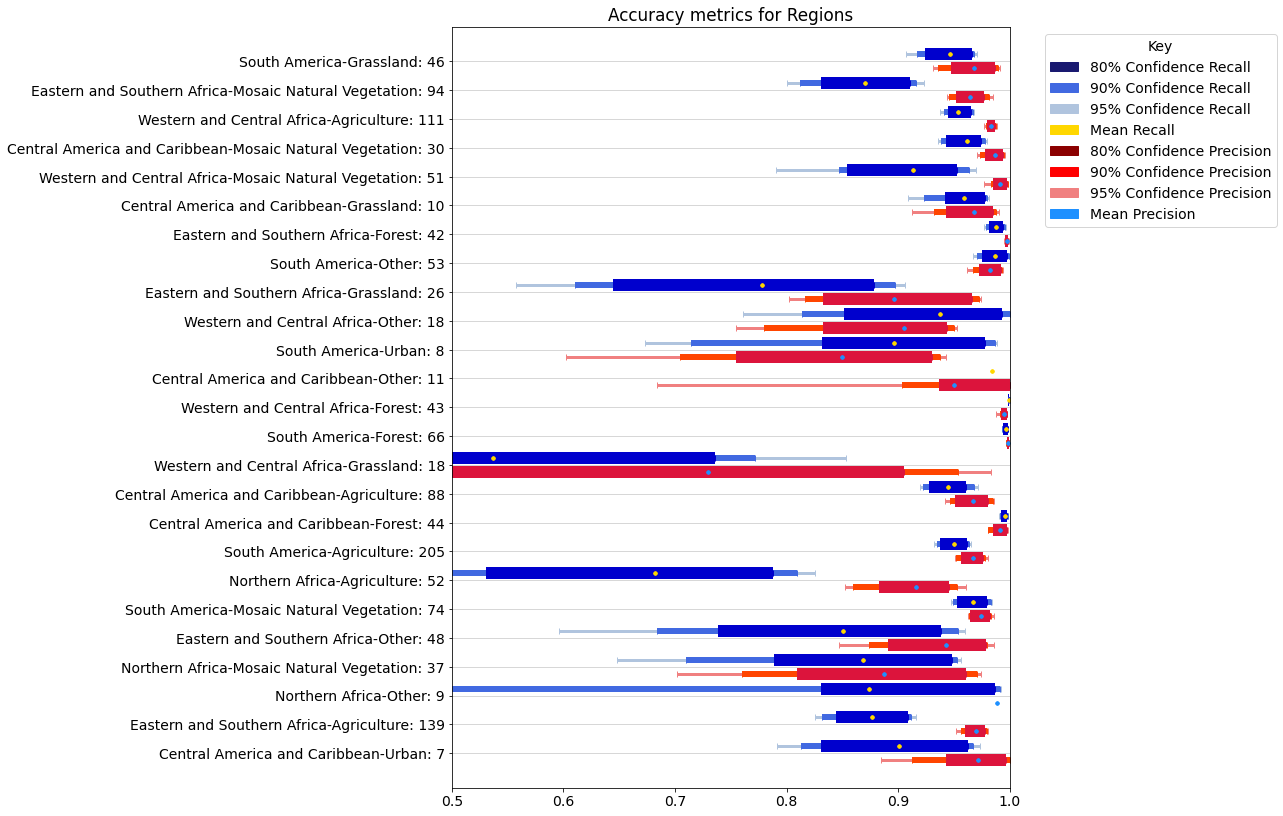

In [374]:
errorplot_precision_recall(subcover_conf, (10,14), 'Regions')

# Overall - Agriculture
# Overall - Forest
# Overall - Urban
# Overall - Grassland
# Overall - Otherland

# Central America and Caribbean - Overall
# Central America and Caribbean - Agriculture
# Central America and Caribbean - Forest
# Central America and Caribbean - Mosaic Natural Vegetation

# Eastern and Southern Africa - Overall
# Eastern and Southern Africa - Agriculture
# Eastern and Southern Africa - Forest
# Eastern and Southern Africa - Mosaic Natural Vegetation

# Northern Africa - Overall
# Northern Africa - Agriculture
# Northern Africa - Forest
# Northern Africa - Mosaic Natural Vegetation

# Eastern and Southern Africa - Overall
# Eastern and Southern Africa - Agriculture
# Eastern and Southern Africa - Forest
# Eastern and Southern Africa - Mosaic Natural Vegetation



### Subregion

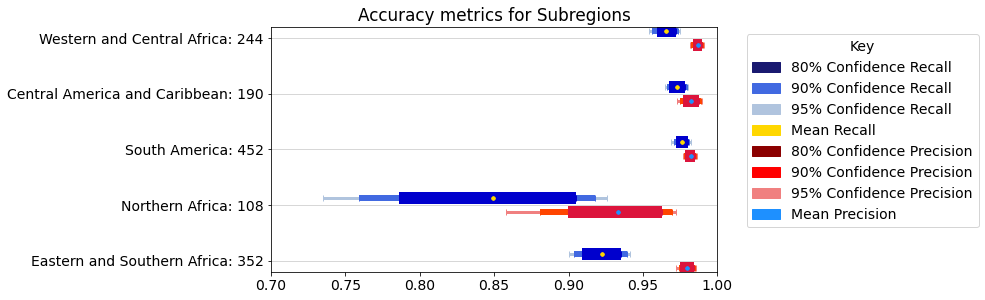

In [370]:
errorplot_precision_recall(subregion_conf, (8, 4.5), 'Subregions')
plt.savefig("subregion.pdf", dpi = 200, bbox_inches = "tight")


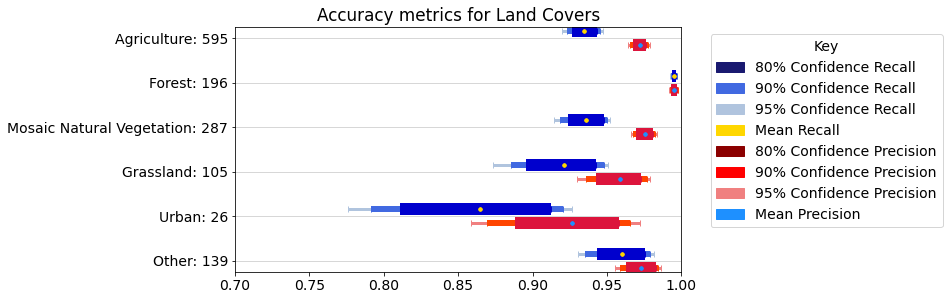

In [369]:
errorplot_precision_recall(lulc_conf, (8,4.5), 'Land Covers')
plt.savefig("lulc.pdf", dpi = 200, bbox_inches = "tight")

### Biomes

In [ ]:
errorplot_precision_recall(biome_conf, (10,6), 'Biomes')

### Tree Class

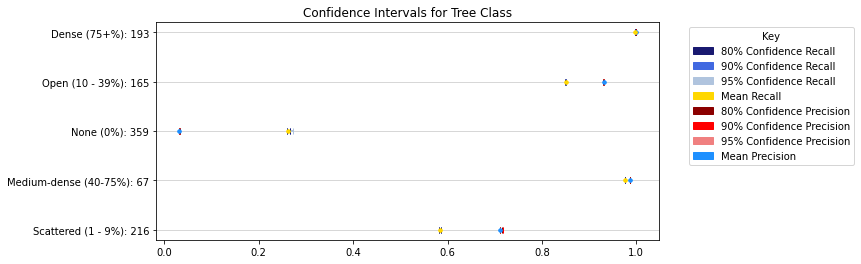

In [69]:
errorplot_precision_recall(treeclass_conf, (9,4), 'Tree Class')

### Ecoregion

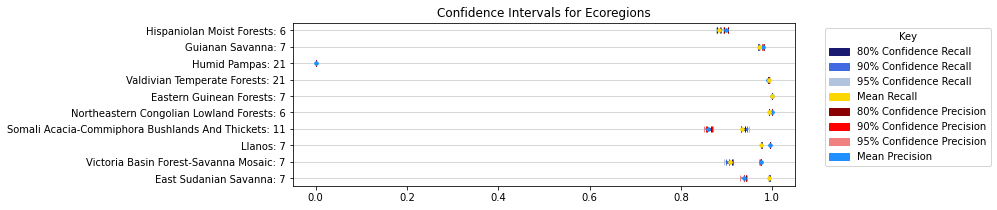

In [80]:
errorplot_precision_recall(ecoreg_conf[15:25], (9,3), 'Ecoregions')

### Country

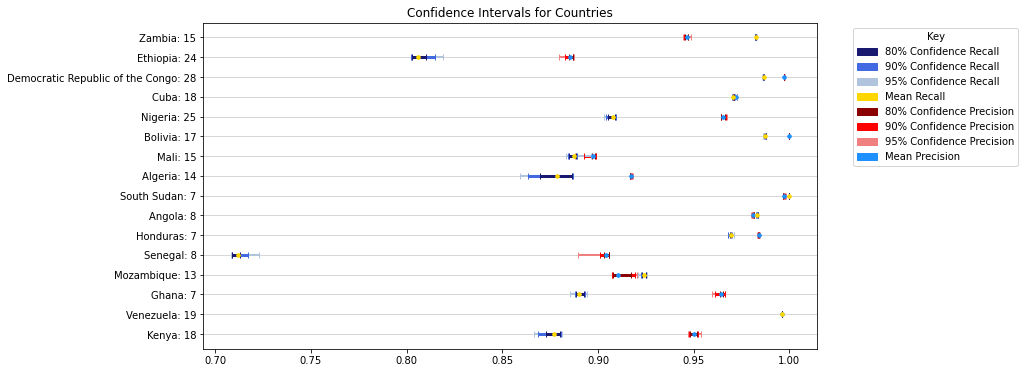

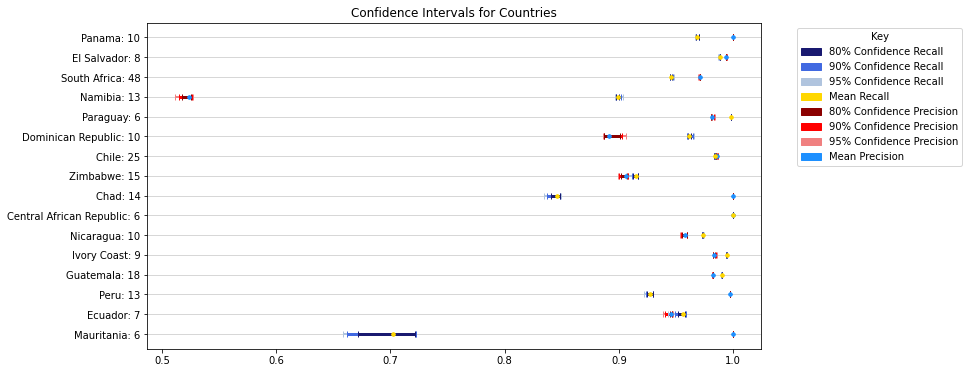

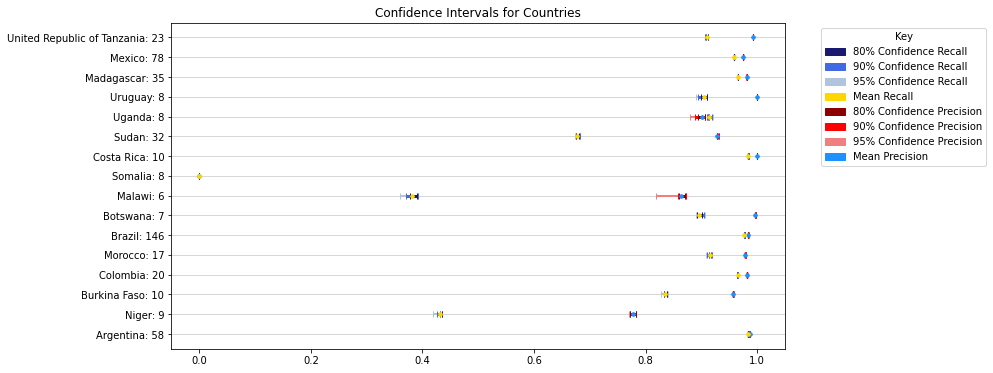

In [79]:
errorplot_precision_recall(country_conf[:16], (11,6), 'Countries')
errorplot_precision_recall(country_conf[16:32], (11,6), 'Countries')
errorplot_precision_recall(country_conf[32:], (11,6), 'Countries')

### Conclusions

We have $50k to spend on getting more validation analyses. Which countries or subregions do we prioritize?
Why the discrepencies between John's slides?
Should we try to prioritize biomes with mixed trees/shrubs?